# Analysis Jupyter Notebook
#### Controlla il path della cartella

## Data Handling
### Creation of the aggregation matrix and indexing the fibrils

In [38]:
import gromacs
from gromacs.fileformats import * #NDX, uniqueNDX
from gromacs import cbook

### Command for clustsize
#!{'rm \#*'}
#clust_cmd = 'gmx_mpi clustsize -f prod_2000-1mM.xtc -dt 100000 -s prod_2000-1mM.tpr -mol -hct -nice 0 -cut 0.4'
#!{clust_cmd}
#!{'rm \#*'}
#!{"sed -i 's/clust /clust_/g' maxclust.ndx"}

#print(gromacs.release())

### Import the index as uniqueNDX to perform some operations
maxclust_ndx = uniqueNDX('maxclust.ndx')

### Creation of a dictionary which includes the index names and the atomnumber
maxclust_dict = maxclust_ndx.sizes

### Extraction of all the clusters, remove the max_clust (duplicated) and make a list of them
fibril_dict = {key:val for key, val in maxclust_dict.items() if val != 85}
fibril_list = list(fibril_dict.keys())
fibril_list.remove('max_clust_')

### Extraction of all the single molecules not part of a fibril and make a list of that
not_fibril_dict = {key:val for key, val in maxclust_dict.items() if val == 85}
not_fibril_list = list(not_fibril_dict.keys())

### Print the lists to paste below
print('Fibril list', '\n', fibril_list)
print('Not Fibril list', '\n', not_fibril_list)

### controlla che siano in ordine i gruppi in max

Fibril list 
 ['clust_1113', 'clust_791', 'clust_1199', 'clust_1665', 'clust_849', 'clust_846', 'clust_875', 'clust_1035', 'clust_1224', 'clust_1390', 'clust_1146', 'clust_321', 'clust_1194']
Not Fibril list 
 ['clust_263', 'clust_302', 'clust_318', 'clust_319', 'clust_396', 'clust_657', 'clust_709', 'clust_741', 'clust_766', 'clust_823', 'clust_895', 'clust_997', 'clust_1133', 'clust_1190', 'clust_1225', 'clust_1235', 'clust_1245', 'clust_1266', 'clust_1297', 'clust_1299', 'clust_1308', 'clust_1456', 'clust_1492', 'clust_1600', 'clust_1657', 'clust_1669', 'clust_1768', 'clust_1887', 'clust_1915']


In [44]:
import string

### Creation of one indexe which includes all the atoms in a cluster
#full_ndx['fibril'] = full_ndx.join('clust 1113', 'clust 791', 'clust 1199', 'clust 1665', 'clust 849', 'clust 846', 'clust 875', 'clust 1035', 'clust 1224', 'clust 1390', 'clust 1146', 'clust 321', 'clust 1194')

### Creation of a second index which includes all the atoms not in a fibril
maxclust_ndx['not_fibril'] = maxclust_ndx.join('clust_263', 'clust_302', 'clust_318', 'clust_319', 'clust_396', 'clust_657', 'clust_709', 'clust_741', 'clust_766', 'clust_823', 'clust_895', 'clust_997', 'clust_1133', 'clust_1190', 'clust_1225', 'clust_1235', 'clust_1245', 'clust_1266', 'clust_1297', 'clust_1299', 'clust_1308', 'clust_1456', 'clust_1492', 'clust_1600', 'clust_1657', 'clust_1669', 'clust_1768', 'clust_1887', 'clust_1915')


### Write the new index which will be used to create a different set of pdbs and used to create a pdb with the correct atom number (pdb numerical limit to 6 digits)
maxclust_ndx.write('pdb.ndx')


### Print the values to print into the script
array1 = range(0, (len(fibril_list)-1)) # Da 0 a 12, i gruppi di maxclust meno maxclust
for a in array1:
    print('"', a , end = '" ', sep = '')
print('"', (len(maxclust_ndx)-1), '"', sep = '')

array3 = range(0, (len(fibril_list)-1)) # Da 0 a 12, i gruppi di maxclust meno maxclust
for a in array1:
    print('"', a , end = '" ', sep = '')

print('\n')

array2 = list(map(chr, range(97, (97+len(array1)))))
for a in array2:
    print('"', a.upper() , end = '" ', sep = '')
print('"Z"')


#fib = full_ndx['fibril']
#not_fib = full_ndx['not_fibril']
#print(len(full_ndx['fibril']))
#print(len(full_ndx['not_fibril']))     # Questi sono ok, 170000 totali

"0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11" "43"
"0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11" 

"A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "Z"


In [45]:
# Array 1 and 2 are used in the chain label script where it is included also the not-fibril
# Array 3 is used the rdf script where you care about only the fibrils

array1_paste = '"0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11" "43"'
array3_paste = '"0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11"'
array2_paste = '"A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "Z"'


### Script for chain labelling

In [46]:
# This script creates a unique pdb with the different fibril are separated in different chains.
# It is necessary to create a pdb and esp files where the second has a correct atom number and the first has a correct formatting

# Script head where you state the number of fibril you want to label in the chain (array1_paste)
# and also the chain identifier (array2_paste)

with open('script-pdb.sh', 'w') as f:
    print('#!/bin/bash', file = f)
    print('# for-loopcmd.sh', '\n', file = f)
    print('# the two arrays are based on the maxclust.ndx -> check which clust is the one you want', file = f)
    print('array=(',array1_paste,')', file = f, sep = '')
    print('array2=(', array2_paste, ')', '\n', '\n', file = f, sep = '')

# For each fibril you want to obtain the pdb and the esp files.

    print('for ((i=0;i<${#array[@]}; ++i)); do', file = f)
    print('\t', r"echo -e ${array[i]} \n | gmx_mpi editconf -f prod_2000-1mM.tpr -n pdb.ndx -label ${array2[i]} -o clust${array[i]}.pdb", file = f)
    print('\t', r"echo -e ${array[i]} \n | gmx_mpi editconf -f prod_2000-1mM.tpr -n pdb.ndx -label ${array2[i]} -o clust${array[i]}.esp", file = f)

# Here the script takes the atom number from the esp file and paste into a temporary file

    print('\t', r"sed 's/{//' clust${array[i]}.esp | awk '{print $1+1}' > numero${array[i]}", file = f)

# Here you add a line with "1" to align the numbers with the correct atom to paste into the pdb

    print('\t', r"sed -i '1s/^/1\n/' numero${array[i]}", file = f)

# Here you paste the number in the pdb file and save into another temp file

    print('\t', r"paste numero${array[i]} clust${array[i]}.pdb > chain${array[i]}", file = f)

# This step append all the pdbs and extract only the atoms.
# Also you sort the atoms based on their real atom number and save into a temporary pdb file full with the fibril and not-fibril

    print('\t', r"cat chain* | grep ATOM | sort -k1 -g > temp_label-chain.pdb", file = f)
    print(r"done", '\n', file = f)
    print(r"rm numero*", file = f)
    print(r"rm chain*", file = f)
    print(r"rm clust*.esp", file = f)

# In this step you delete the first column which is the atom number from the esp file and save into the final pdb file

    print(r"cut -f 1 --complement temp_label-chain.pdb > label-chain.pdb", file = f)
    print(r"rm temp_label-chain.pdb", file = f)
    print(r"rm \#*", file = f)
    print(r"mkdir clust_pdbs", file = f)
    print(r"mv clust*.pdb clust_pdbs/", file = f)
    print(r"exit", file = f)
  
!{'chmod +x script-pdb.sh'}
!{'./script-pdb.sh'}
print('DONE')

Invalid MIT-MAGIC-COOKIE-1 key                :-) GROMACS - gmx editconf, 2020.3-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                      

### Script for RDF analysis for each cluster

In [47]:
# This script is used to compute the rdf for each fibril divided in 11 steps
# e.g. clust 1 has 11 rdf which will be merged into a single plot and see how the rdf changes in time

# dt and last time defines the length of the trajectory used to obtain the rdf and also every timestep you want (you don't need much)
# In this case you have a 500'000 ps to divide in 50'000 which results in 10 steps of rdf

dt = 50000 # this number will determine how many rdfs you'll have
last_time = 500000 # last time in ps

# Head of the script where you basically tell the fibrils to analyse (array3_paste)

with open('script-cluster.sh', 'w') as f:
    print('#!/bin/bash', file = f)
    print('# for-loopcmd.sh', '\n', file = f)
    print('# This script makes different pdb in different steps and calculate the rdf', file = f)
    print('# First, makes a trajectory with the frames at the ts we want', file = f)
    print('# Second, makes based on the pdbs, it computes the rdf', file = f)
    print('array=(',array3_paste,')', file = f, sep = '')
    print('mkdir rdf', '\n', '\n', file = f)

# This step makes pdb files used to select the steps to compute the rdf

    print(r"echo -e 0 \n 0 \n | gmx_mpi trjconv -f prod_2000-1mM.xtc -s prod_2000-1mM.tpr -dt", dt, "-e", last_time, "-o rdf/step_.pdb -sep", file = f)

# This loop computes the trajectory for each fibril in a way where every frame is a step to compare the rdf

    print('for ((i=0;i<${#array[@]}; ++i)); do', file = f)
    print('\t', r"echo ${array[i]} ${array[i]} \n | gmx_mpi trjconv -f prod_2000-1mM.xtc -s prod_2000-1mM.tpr -n pdb.ndx -dt", dt, "-e", last_time, "-center -pbc mol -o rdf/traj_${array[i]}", '\n', file = f)
    print('\t', r"for ((z=0; z<11; z++)); do", file = f)   

# This secondary loop is the one that actually computes the rdf of each fibril every n steps (depending on the ratio last_time/dt)

    print('\t', '\t', r'printf "${array[i]} \n ${array[i]} \n" | gmx_mpi rdf -f rdf/step_$z.pdb -o rdf/clust_${array[i]}_$z -s prod_2000-1mM.tpr -surf mol -rmax 10 -bin 0.05 -nice 1 -n pdb.ndx', file = f)
    print('\t', r"done", '\n', file = f)

# This step merge all the rdf of each fibril and merges into one. This file will be read using pandas and get a plot for each fibril in time

    print('\t', r'paste rdf/clust_${array[i]}_*.xvg | grep -v "[@:#]" | awk', "'", '{printf $1" "; for(i=2; i<=NF; i=i+2) printf $i" "; print""}', "'", ' > rdf/full_clust_${array[i]}.xvg', '\n', file = f)

    print(r"done", '\n', file = f)

    print(r"rm rdf/#*", file = f)
    print(r"exit", file = f)
  
!{'chmod +x script-cluster.sh'}
!{'./script-cluster.sh'}
print('DONE')

mkdir: cannot create directory ‘rdf’: File exists
Invalid MIT-MAGIC-COOKIE-1 key                 :-) GROMACS - gmx trjconv, 2020.3-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten

### Matrix handling for fibril growth plots

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

%pwd
#%cd /media/data/emanuele/TTR/smog-to-gromos/old/fix-concentration_gradient/make_fibrillone-2000-296K-1mM-bis/analysis

### Data import

matrix = pd.read_csv('histo-time.dat', sep = '\\s+', header = None)

# Changing the index so now it is in picoseconds
#matrix[0] = matrix[0].apply(lambda x:x*10)
#matrix = matrix.set_index([0])

### Data handling
#### Defining the Maxclust and the number of frames
clustsize = list(range(0, len(matrix.columns), 1))
frames = list(range(0, len(matrix.index), 1))
fibril = list(range(2, len(matrix.columns)))
#not_fibril = list(range(3, 10, 1))


#### Multiply the columns for its clustsize
size = pd.Series(clustsize)
matrix = matrix.mul(size, axis = 1)

#### Replace 0 with n.an
matrix[matrix == 0] = np.nan

#### I don't care about monomers
matrix = matrix.drop([0, 1], axis = 1)

### Make the histogram to compare with lab results
# Set the not-fibril to 0 and have a sort of lag time 
histo_zero = matrix.copy()
histo_zero[[2, 3, 4, 5, 6, 7, 8, 9, 10]] = 0
histo_zero = histo_zero[fibril].sum(axis=1)

# This one is the complete one
histogram = matrix[fibril].sum(axis=1)

# Matrix transpose
matrix = matrix.T




#print(matrix)
#print(maxclust) # seems ok
#print(frames) # seems ok

### Matrix Plots

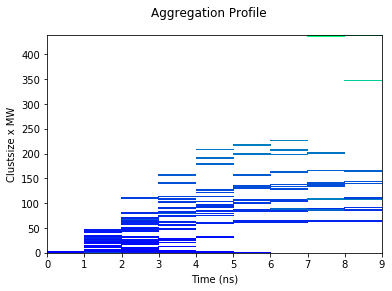

In [49]:
#prova = ListedColormap(['darkorange', 'gold', 'lawngreen', 'lightseagreen'])
plt.pcolormesh(matrix, cmap = 'winter', rasterized = True)
plt.ylabel('Clustsize x MW')
plt.xlabel('Time (ns)')
#splt.xlim(0, 1200)
plt.suptitle('Aggregation Profile')
plt.show()


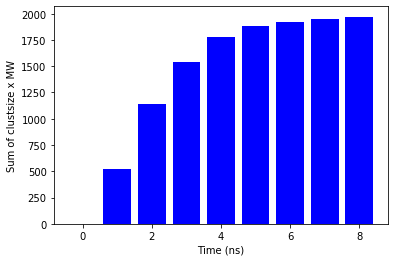

In [55]:
plt.bar(frames, histo_zero, color = 'blue')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 1200)
plt.show()

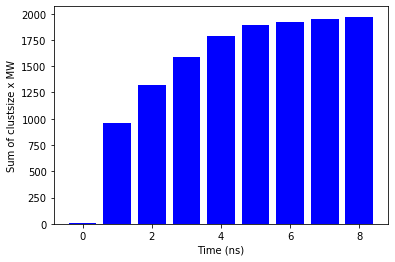

In [51]:
plt.bar(frames, histogram, color = 'blue')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 1200)
plt.show()

### RDF Plots

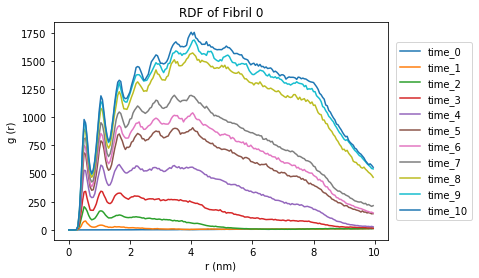

In [70]:
#import pandas as pd
#import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#import matplotlib.ticker
#from matplotlib.colors import ListedColormap
#import glob

#%pwd
#%cd /media/data/emanuele/TTR/smog-to-gromos/old/fix-concentration_gradient/make_fibrillone-2000-296K-1mM-bis/analysis

columns = ['r', 'time_0', 'time_10', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9']
full_clust_0 = pd.read_csv('rdf/full_clust_0.xvg', sep = '\\s+', header = None)
full_clust_0.columns = columns


#print(full_clust_0)

ax = full_clust_0.plot(x = 'r', y = 'time_0', kind = 'line')
full_clust_0.plot(x = 'r', y = 'time_1', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_2', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_3', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_4', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_5', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_6', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_7', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_8', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_9', ax = ax)
full_clust_0.plot(x = 'r', y = 'time_10', ax = ax)
plt.legend(bbox_to_anchor = [1.25, 0.5], loc = 'right', borderaxespad = 0.)
plt.xlabel('r (nm)')
plt.ylabel('g (r)')
plt.title(label = 'RDF of Fibril 0', loc = 'center')
plt.show()



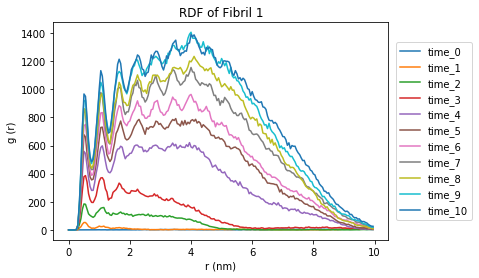

In [71]:
columns = ['r', 'time_0', 'time_10', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9']
full_clust_1 = pd.read_csv('rdf/full_clust_1.xvg', sep = '\\s+', header = None)
full_clust_1.columns = columns


#print(full_clust_0)

ax = full_clust_1.plot(x = 'r', y = 'time_0', kind = 'line')
full_clust_1.plot(x = 'r', y = 'time_1', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_2', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_3', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_4', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_5', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_6', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_7', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_8', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_9', ax = ax)
full_clust_1.plot(x = 'r', y = 'time_10', ax = ax)
plt.legend(bbox_to_anchor = [1.25, 0.5], loc = 'right', borderaxespad = 0.)
plt.xlabel('r (nm)')
plt.ylabel('g (r)')
plt.title(label = 'RDF of Fibril 1', loc = 'center')
plt.show()


### Plumed.dat for cluster analysis

In [53]:
#gyr_type = 'RADIUS'
#string = 'rg_'
#rg_clust = [string + x for x in fibril_list]
#print(rg_clust)

#with open('plumeed.dat', 'w') as f:
#    print(' # Declaring the different groups based on the index', '\n', '\n', file=f)
#    for c in fibril_list:
#        print(c,': GROUP NDX_FILE=pdb.ndx NDX_GROUP=', c, sep='', file=f)
#    print('\n', '\n', '# GYRATION RADIUS', file=f)
#    for c in fibril_list:
#        print('rg_', c, ': GYRATION TYPE=', gyr_type, ' ATOMS=', c, sep='', file=f)
#    print('\n', 'PRINT ARG=', ', '.join(rg_clust), ' FILE=colvar', sep='', file=f)


#!{'rm bck.*'}

In [54]:
#import gmxapi as gmx

#clust = gmx.commandline_operation('gmx_mpi',
 #                                   arguments=['clustsize', '-mol', '-nice', '0', '-cut', '0.4', '-dt', '100000'],
  #                                  input_files={'-f': 'prod_2000-1mM.xtc', '-s': 'prod_2000-1mM.tpr'})